In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [2]:
full_data = datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)
train_size = 55000
val_size = 5000
batch_size = 100
learning_rate = 0.001
epochs = 5
train_data, val_data = random_split(full_data, [train_size, val_size])

test_data = datasets.MNIST(root='data',
                            train=False,
                            transform=ToTensor(),
                            download=True)

In [ ]:
loaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1),
}

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.output = nn.Linear(50, 10)

    def forward(self, x, return_features=False):
        feature_maps = {}
        x = self.conv1(x)
        feature_maps['conv1'] = x
        x = F.relu(F.max_pool2d(x, 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        feature_maps['conv2'] = x
        
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.output(x)

        if return_features:
            return F.softmax(x, dim=1), feature_maps
        return F.softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
train_acc= []
test_acc= []
val_acc = []
losses = []


def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)

        loss = loss_fn(output, target)

        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
    avg_loss = running_loss / len(loaders['train'])
    accuracy = 100. * correct / total
    train_loss.append(avg_loss)
    train_acc.append(accuracy)
    print(f'Train Epoch {epoch}: Training loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%')

def validate():
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loaders['val']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_accuracy = 100. * correct / len(loaders['val'].dataset)
    val_acc.append(val_accuracy)
    print(f'Validation Accuracy: {val_accuracy:.4f}')

def test():
    model.eval()

    total_loss = 0
    correct = 0

    with torch.no_grad():

        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)

            total_loss += loss_fn(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = total_loss / len(loaders['test'])
    accuracy = 100. * correct / len(loaders['test'].dataset)
    
    test_loss.append(avg_test_loss)
    test_acc.append(accuracy)
    
    print(f'Test set: Average Loss: {avg_test_loss:.4f}, Test Accuracy: {correct}/{len(loaders["test"].dataset)} ({accuracy:.2f}%)')

In [ ]:
for epoch in range(epochs):
    train(epoch)
    validate()
    test()

Train Epoch 0: Training loss: 1.7845, Training Accuracy: 68.83%
Validation Accuracy: 84.2800
Test set: Average Loss: 1.6131, Test Accuracy: 8490/10000 (84.90%)
Train Epoch 1: Training loss: 1.6406, Training Accuracy: 82.47%
Validation Accuracy: 94.1800
Test set: Average Loss: 1.5158, Test Accuracy: 9468/10000 (94.68%)
Train Epoch 2: Training loss: 1.5713, Training Accuracy: 89.39%
Validation Accuracy: 95.4200
Test set: Average Loss: 1.5031, Test Accuracy: 9584/10000 (95.84%)
Train Epoch 3: Training loss: 1.5573, Training Accuracy: 90.70%
Validation Accuracy: 95.9200
Test set: Average Loss: 1.4998, Test Accuracy: 9623/10000 (96.23%)
Train Epoch 4: Training loss: 1.5455, Training Accuracy: 91.83%
Validation Accuracy: 96.4600
Test set: Average Loss: 1.4956, Test Accuracy: 9658/10000 (96.58%)


In [12]:
device
torch.save(model.state_dict(), 'trained_model_mnist.pth')

Train Loss: [1.7845266363837502, 1.6405512768572028, 1.5712702623280612, 1.5573089675469831, 1.545483286814256]
Test Loss: [1.6131471157073975, 1.5158000409603118, 1.503136476278305, 1.4997680163383484, 1.4955641973018645]


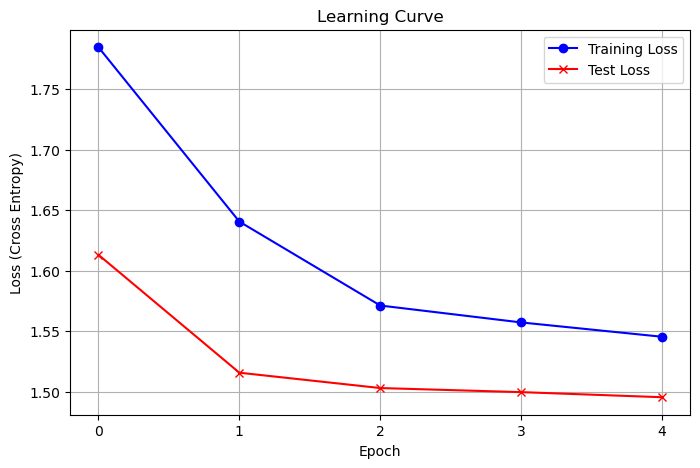

In [13]:
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(range(epochs), test_loss, label='Test Loss', color='red', marker='x')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid()
plt.xticks(range(epochs))
plt.show()

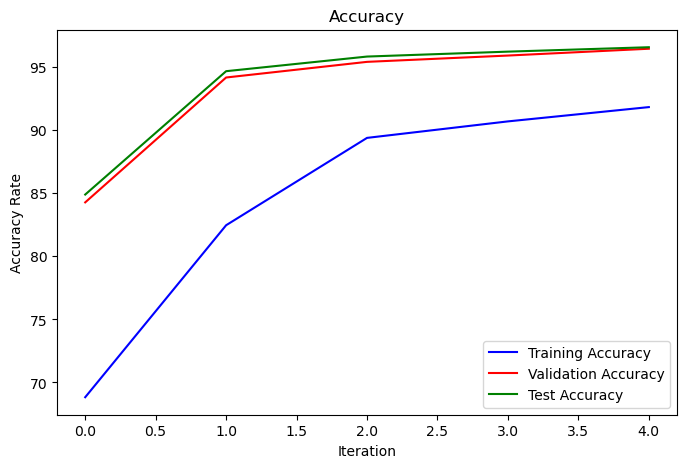

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('Accuracy')
plt.plot(train_acc, label="Training Accuracy", c='b')
plt.plot(val_acc, label="Validation Accuracy",c='r')
plt.plot(test_acc, label="Test Accuracy", c='g')
plt.xlabel("Iteration")
plt.ylabel("Accuracy Rate")
plt.legend()
plt.show()

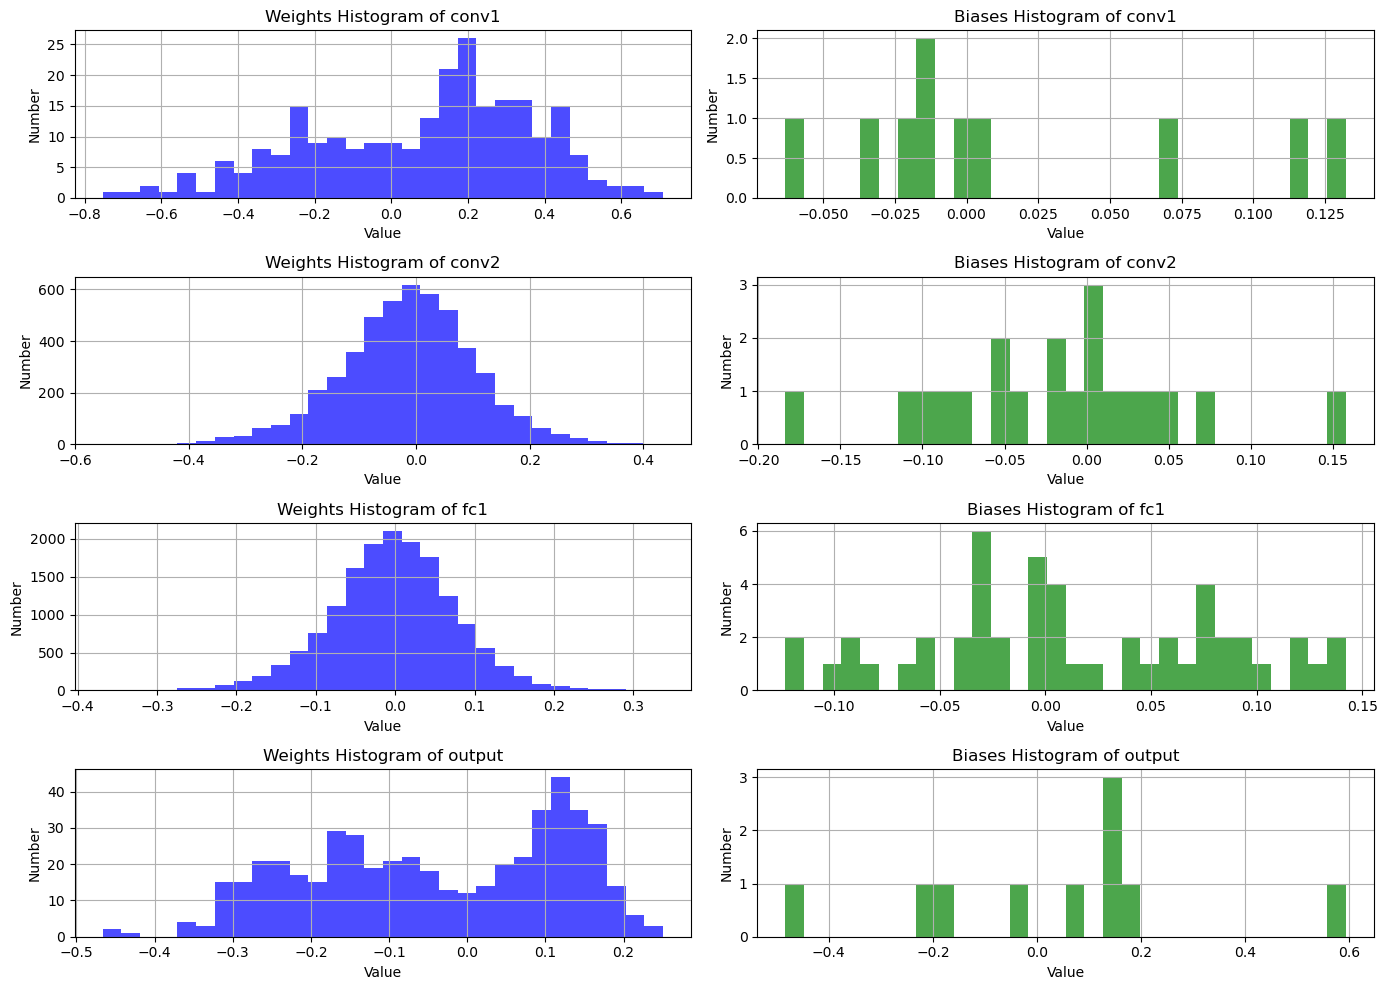

In [ ]:
def weight_bias_hist(model):
    layers = ['conv1', 'conv2', 'fc1', 'output']
    
    plt.figure(figsize=(14, 10))
    
    for i, layer_name in enumerate(layers):
        weights = getattr(model, layer_name).weight.data.cpu().numpy().flatten()
        biases = getattr(model, layer_name).bias.data.cpu().numpy()


        plt.subplot(4, 2, i * 2 + 1)
        plt.hist(weights, bins=30, alpha=0.7, color='blue')
        plt.title(f'Weights Histogram of {layer_name}')
        plt.xlabel('Value')
        plt.ylabel('Number')
        plt.grid()


        plt.subplot(4, 2, i * 2 + 2)
        plt.hist(biases, bins=30, alpha=0.7, color='green')
        plt.title(f'Biases Histogram of {layer_name}')
        plt.xlabel('Value')
        plt.ylabel('Number')
        plt.grid()

    plt.tight_layout()
    plt.show()


weight_bias_hist(model)

Prediction:7


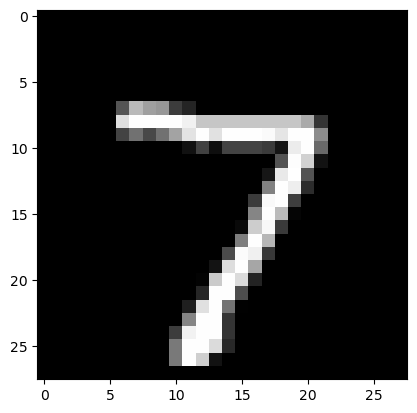

In [16]:
model.eval()

data, target = test_data[0]
data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction:{prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()

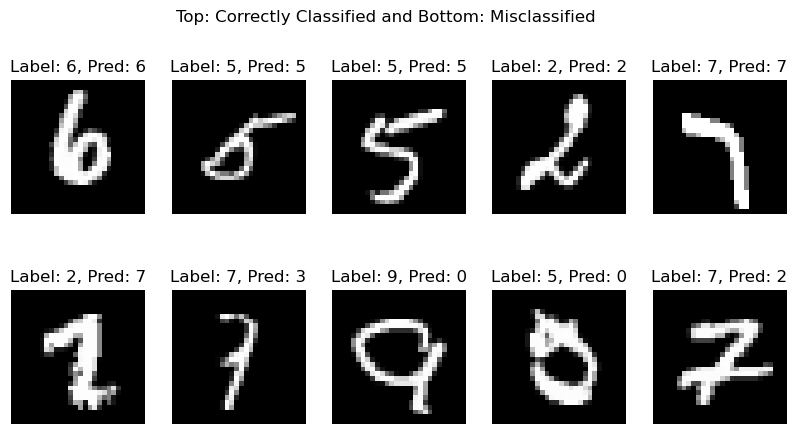

In [ ]:
def predictions(model, loader, num_examples=5):
    model.eval()
    correct_images = []
    incorrect_images = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            for i in range(len(pred)):
                if len(correct_images) < num_examples and pred[i] == target[i]:
                    correct_images.append((data[i].cpu(), target[i].item(), pred[i].item()))
                elif len(incorrect_images) < num_examples and pred[i] != target[i]:
                    incorrect_images.append((data[i].cpu(), target[i].item(), pred[i].item()))

            if len(correct_images) >= num_examples and len(incorrect_images) >= num_examples:
                break

    fig, axs = plt.subplots(2, num_examples, figsize=(10, 5))
    for i, (img, label, pred) in enumerate(correct_images):
        axs[0, i].imshow(img.squeeze(), cmap='gray')
        axs[0, i].set_title(f'Label: {label}, Pred: {pred}')
        axs[0, i].axis('off')

    for i, (img, label, pred) in enumerate(incorrect_images):
        axs[1, i].imshow(img.squeeze(), cmap='gray')
        axs[1, i].set_title(f'Label: {label}, Pred: {pred}')
        axs[1, i].axis('off')

    plt.suptitle('Top: Correctly Classified and Bottom: Misclassified')
    plt.show()


predictions(model, loaders['test'])

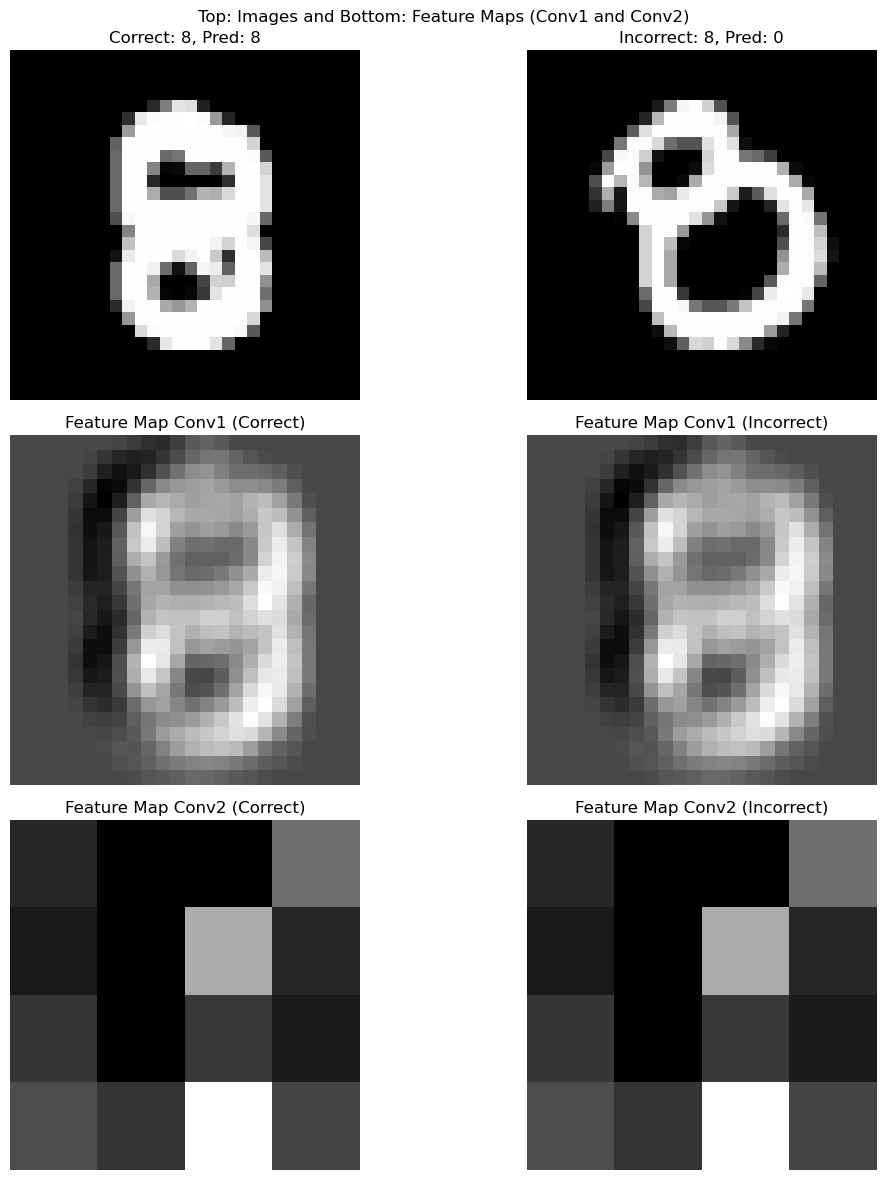

In [ ]:
def feat_map(model, loader):
    model.eval()
    correct_image = None
    incorrect_image = None

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output, feature_maps = model(data, return_features=True)
            pred = output.argmax(dim=1)

            for i in range(len(pred)):
                if correct_image is None and pred[i] == target[i]:
                    correct_image = (data[i].cpu(), target[i].item(), pred[i].item(), feature_maps)
                elif incorrect_image is None and pred[i] != target[i]:
                    incorrect_image = (data[i].cpu(), target[i].item(), pred[i].item(), feature_maps)

                if correct_image is not None and incorrect_image is not None:
                    break
            if correct_image is not None and incorrect_image is not None:
                break

    fig, axs = plt.subplots(3, 2, figsize=(12, 12))

    img, label, pred, feature_maps = correct_image
    axs[0, 0].imshow(img.squeeze(), cmap='gray')
    axs[0, 0].set_title(f'Correct: {label}, Pred: {pred}')
    axs[0, 0].axis('off')

    feature_map_conv1 = feature_maps['conv1'][0].cpu().detach().numpy()[0]
    axs[1, 0].imshow(feature_map_conv1, cmap='gray')
    axs[1, 0].set_title('Feature Map Conv1 (Correct)')
    axs[1, 0].axis('off')

    feature_map_conv2 = feature_maps['conv2'][0].cpu().detach().numpy()[0]
    axs[2, 0].imshow(feature_map_conv2, cmap='gray')
    axs[2, 0].set_title('Feature Map Conv2 (Correct)')
    axs[2, 0].axis('off')

    img, label, pred, feature_maps = incorrect_image
    axs[0, 1].imshow(img.squeeze(), cmap='gray')
    axs[0, 1].set_title(f'Incorrect: {label}, Pred: {pred}')
    axs[0, 1].axis('off')

    feature_map_conv1 = feature_maps['conv1'][0].cpu().detach().numpy()[0]
    axs[1, 1].imshow(feature_map_conv1, cmap='gray')
    axs[1, 1].set_title('Feature Map Conv1 (Incorrect)')
    axs[1, 1].axis('off')

    feature_map_conv2 = feature_maps['conv2'][0].cpu().detach().numpy()[0]
    axs[2, 1].imshow(feature_map_conv2, cmap='gray')
    axs[2, 1].set_title('Feature Map Conv2 (Incorrect)')
    axs[2, 1].axis('off')

    plt.suptitle('Top: Images and Bottom: Feature Maps (Conv1 and Conv2)')
    plt.tight_layout()
    plt.show()

feat_map(model, loaders['test'])



In [ ]:
# L2 regularization coefficient
L2_REG = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2_REG) 
loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
train_acc= []
test_acc= []
val_acc = []
losses = []


def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)

        loss = loss_fn(output, target)

        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
        losses.append(loss.item())
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
    avg_loss = running_loss / len(loaders['train'])
    accuracy = 100. * correct / total
    train_loss.append(avg_loss)
    train_acc.append(accuracy)
    print(f'Train Epoch {epoch}: Training loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%')

def validate():
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loaders['val']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_accuracy = 100. * correct / len(loaders['val'].dataset)
    val_acc.append(val_accuracy)
    print(f'Validation Accuracy: {val_accuracy:.4f}')

def test():
    model.eval()

    total_loss = 0
    correct = 0

    with torch.no_grad():

        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)

            total_loss += loss_fn(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = total_loss / len(loaders['test'])
    accuracy = 100. * correct / len(loaders['test'].dataset)
    
    test_loss.append(avg_test_loss)
    test_acc.append(accuracy)
    
    print(f'Test set: Average Loss: {avg_test_loss:.4f}, Test Accuracy: {correct}/{len(loaders["test"].dataset)} ({accuracy:.2f}%)')

In [6]:
for epoch in range(epochs):
    train(epoch)
    validate()
    test()

Train Epoch 0: Training loss: 1.7893, Training Accuracy: 68.23%
Validation Accuracy: 84.7400
Test set: Average Loss: 1.6107, Test Accuracy: 8519/10000 (85.19%)
Train Epoch 1: Training loss: 1.6505, Training Accuracy: 81.52%
Validation Accuracy: 86.0000
Test set: Average Loss: 1.5974, Test Accuracy: 8639/10000 (86.39%)
Train Epoch 2: Training loss: 1.5908, Training Accuracy: 87.45%
Validation Accuracy: 95.5200
Test set: Average Loss: 1.5049, Test Accuracy: 9562/10000 (95.62%)
Train Epoch 3: Training loss: 1.5511, Training Accuracy: 91.43%
Validation Accuracy: 96.3000
Test set: Average Loss: 1.4957, Test Accuracy: 9660/10000 (96.60%)
Train Epoch 4: Training loss: 1.5383, Training Accuracy: 92.61%
Validation Accuracy: 97.0200
Test set: Average Loss: 1.4894, Test Accuracy: 9722/10000 (97.22%)


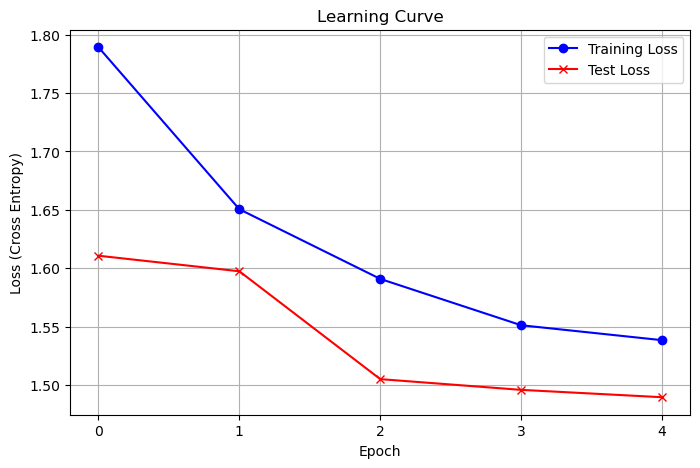

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(range(epochs), test_loss, label='Test Loss', color='red', marker='x')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid()
plt.xticks(range(epochs))
plt.show()

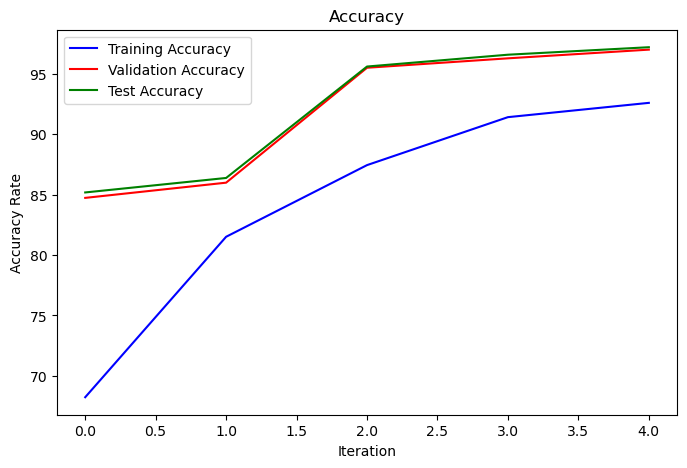

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('Accuracy')
plt.plot(train_acc, label="Training Accuracy", c='b')
plt.plot(val_acc, label="Validation Accuracy",c='r')
plt.plot(test_acc, label="Test Accuracy", c='g')
plt.xlabel("Iteration")
plt.ylabel("Accuracy Rate")
plt.legend()
plt.show()

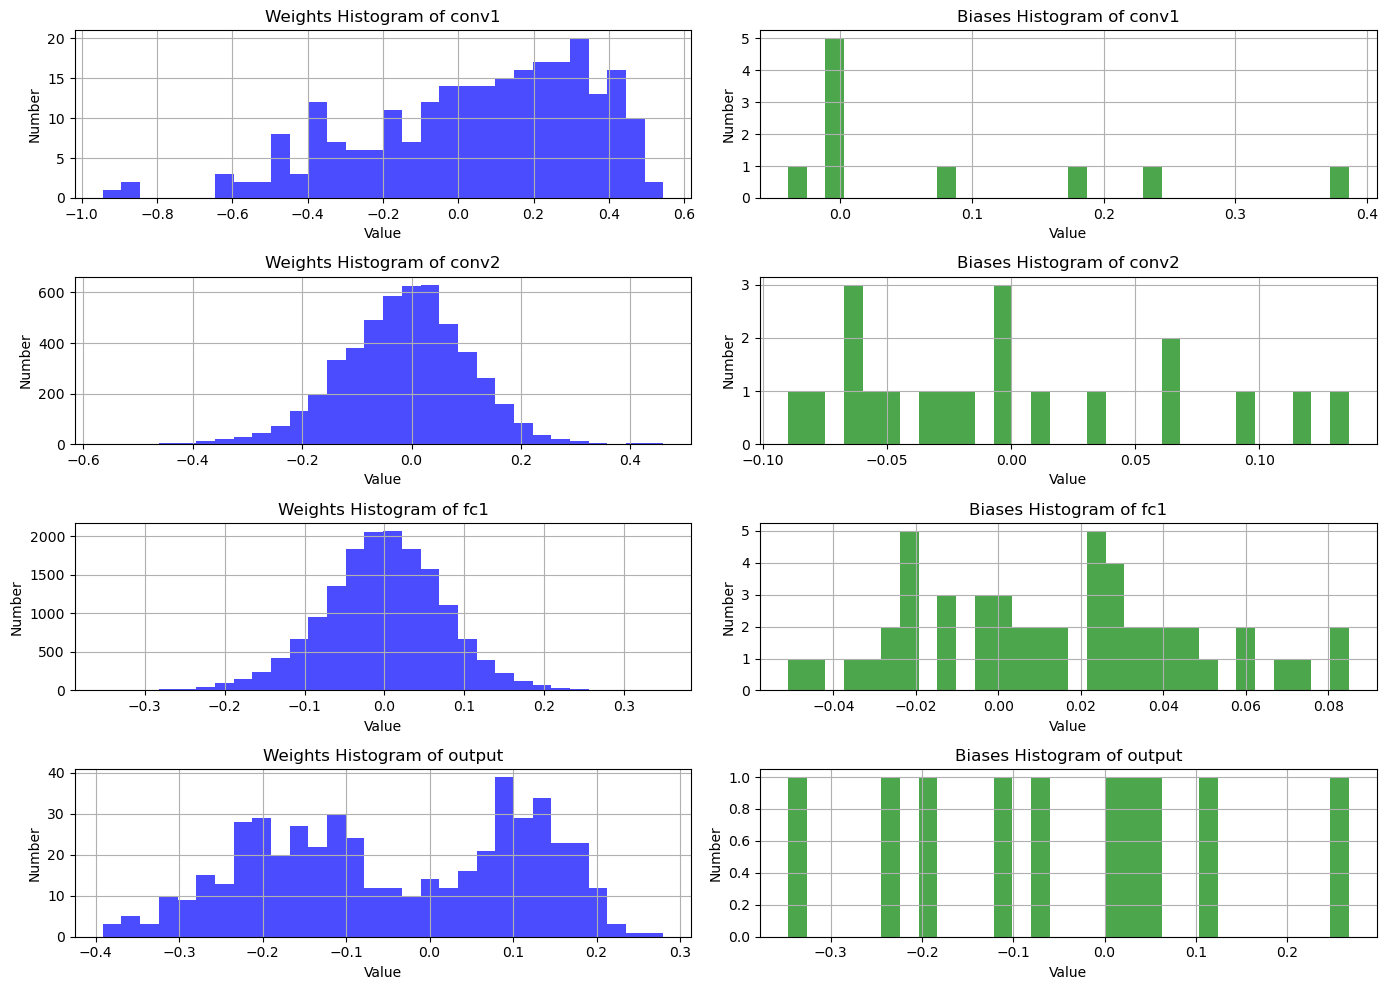

In [ ]:
def weight_bias_hist(model):
    layers = ['conv1', 'conv2', 'fc1', 'output']
    
    plt.figure(figsize=(14, 10))
    
    for i, layer_name in enumerate(layers):
        weights = getattr(model, layer_name).weight.data.cpu().numpy().flatten()
        biases = getattr(model, layer_name).bias.data.cpu().numpy()

        plt.subplot(4, 2, i * 2 + 1)
        plt.hist(weights, bins=30, alpha=0.7, color='blue')
        plt.title(f'Weights Histogram of {layer_name}')
        plt.xlabel('Value')
        plt.ylabel('Number')
        plt.grid()

        plt.subplot(4, 2, i * 2 + 2)
        plt.hist(biases, bins=30, alpha=0.7, color='green')
        plt.title(f'Biases Histogram of {layer_name}')
        plt.xlabel('Value')
        plt.ylabel('Number')
        plt.grid()

    plt.tight_layout()
    plt.show()


weight_bias_hist(model)